# In-host dynamics of SARS-CoV-2
Based on two articles: 
* Within Host Dynamics of SARS‑CoV‑2 in Humans: Modeling Immune
Responses and Antiviral Treatments;
Indrajit Ghosh
* Modelling of the Innate and Adaptive Immune Response to
SARS Viral Infection, Cytokine Storm and Vaccination;
Cristina Leon, Alexey Tokarev, Anass Bouchnita and Vitaly Volpert

1. Start from simple **compatmental model** of virus-host cell dynamics
- H(t)=healthy uninfected cells
- V(t)=free virus
- I(t)=infected cells

Infected cells I produce virus particles V that leave the cell and find other susceptible target cells H.



In [7]:
# imports
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


A virus-clearance event was implemented uniformly across all models by terminating numerical integration when the viral load dropped below a fixed threshold.

Numerical integration was terminated once the viral load dropped below a clearance threshold 
V<10^−6
, reflecting effective elimination of the virus and preventing unnecessary computation in the post-clearance regime.

The viral load is negligible compared to biologically relevant levels.
* Below detection limit
* Immune clearance achieved
* No further biological impact

Although viral particles and cells are discrete entities, the model describes average concentrations and is formulated as a deterministic ODE system. Consequently, viral clearance is defined operationally by a small threshold value rather than an exact zero, corresponding to a viral load below biologically relevant or detectable levels. To have proper extinction we should have a stochastic model

In [22]:
def virus_clearance_event(t, y, *args):
    V = y[2]          # virus variable
    V_clear = 1e-6    # clearance threshold
    return V - V_clear

virus_clearance_event.terminal = True   # stop integration
virus_clearance_event.direction = -1    # only trigger when decreasing


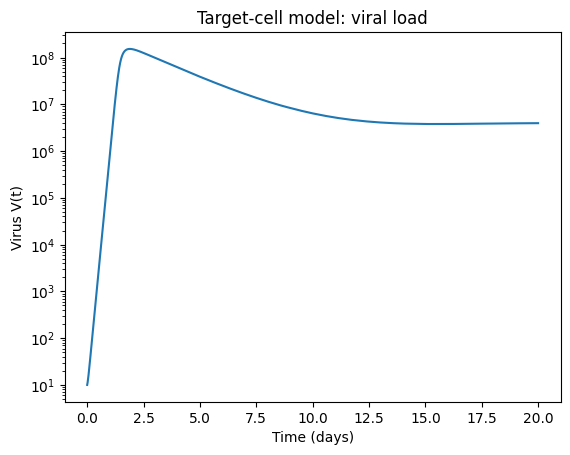

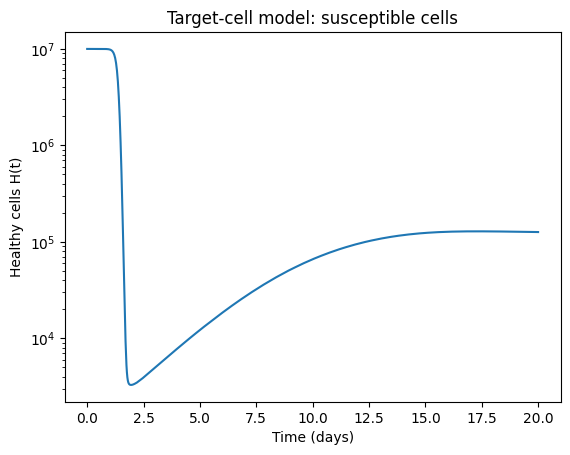

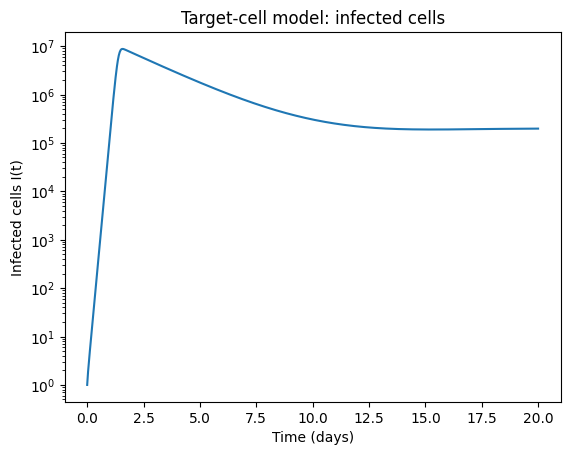

In [23]:
# simple compartmental model
def target_cell_model(t, y, params):
    H, I, V = y
    λ, β, μ1, μ2, μ3, k = params

    dHdt = λ - β * H * V - μ1 * H
    dIdt = β * H * V - μ2 * I
    dVdt = k * I - μ3 * V

    return [dHdt, dIdt, dVdt]

params_tc = [
    1e5,    # λ  healthy cell production
    2e-7,   # β  infection rate
    0.01,   # μ1 healthy cell death
    0.5,    # μ2 infected cell death
    5.0,    # μ3 virus clearance
    100.0   # k  virus production
]

y0_tc = [1e7, 1.0, 10.0]  # H, I, V
t_span = (0, 20)
t_eval = np.linspace(0, 20, 1000)

sol_tc = solve_ivp(
    target_cell_model, t_span, y0_tc,
    args=(params_tc,), t_eval=t_eval, 
    events=virus_clearance_event
)

plt.plot(sol_tc.t, sol_tc.y[2])
plt.yscale("log")
plt.xlabel("Time (days)")
plt.ylabel("Virus V(t)")
plt.title("Target-cell model: viral load")
plt.show()

plt.plot(sol_tc.t, sol_tc.y[0])
plt.yscale("log")
plt.xlabel("Time (days)")
plt.ylabel("Healthy cells H(t)")
plt.title("Target-cell model: susceptible cells")
plt.show()

plt.plot(sol_tc.t, sol_tc.y[1])
plt.yscale("log")
plt.xlabel("Time (days)")
plt.ylabel("Infected cells I(t)")
plt.title("Target-cell model: infected cells")
plt.show()


2. Add innate immune response

Innate immune response works non-specifically and immediately. 
Cytokines C(t) inhibit viral replication. Specific cytokines activate Netural Killer cells N(t), which kill virus-infected cells.
IMMUNODEPRESSI!!!!


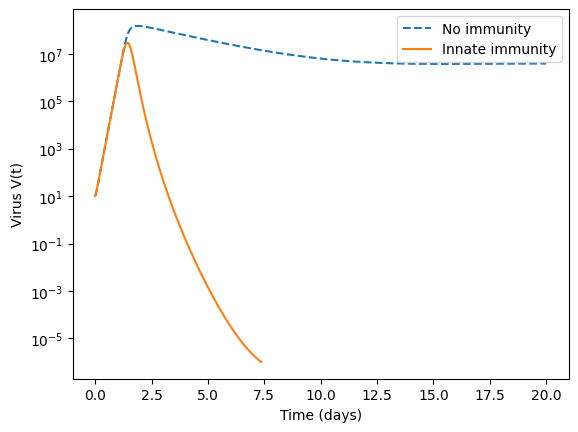

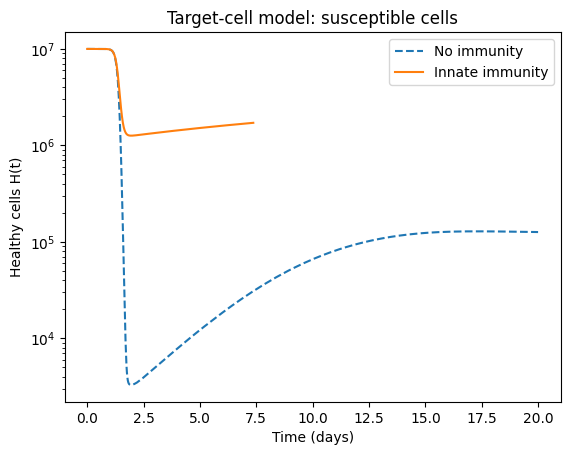

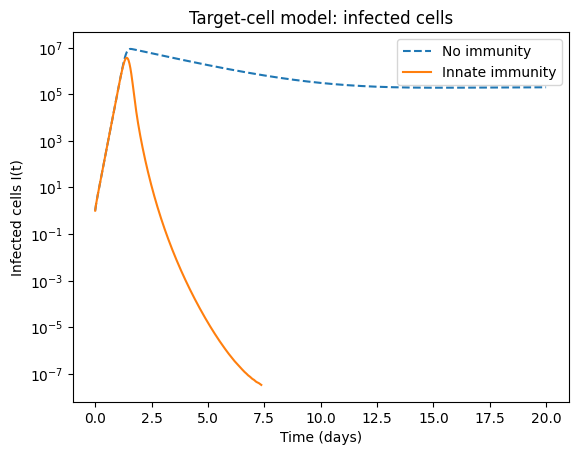

In [27]:
def innate_model(t, y, params):
    H, I, V, C, N = y
    λ, β, μ1, μ2, μ3, k, pC, pN, rC, μC, μN = params

    dHdt = λ - β * H * V - μ1 * H
    dIdt = β * H * V - pN * N * I - μ2 * I
    dVdt = k * I - pC * C * V - μ3 * V
    dCdt = rC * I - μC * C
    dNdt = rC * C - μN * N

    return [dHdt, dIdt, dVdt, dCdt, dNdt]

params_innate = [
    1e5, 2e-7, 0.01, 0.5, 5.0, 100.0,
    1e-5,   # pC cytokine virus inhibition
    1e-4,   # pN NK killing
    1.0,    # rC cytokine production
    1.0,    # μC cytokine decay
    0.5     # μN NK decay
]

y0_innate = [1e7, 1.0, 10.0, 0.0, 0.0]

sol_innate = solve_ivp(
    innate_model, t_span, y0_innate,
    args=(params_innate,), t_eval=t_eval,
    rtol=1e-5, atol=1e-8,
    events=virus_clearance_event
)


plt.plot(sol_tc.t, sol_tc.y[2], '--', label="No immunity")
plt.plot(sol_innate.t, sol_innate.y[2], label="Innate immunity")
plt.yscale("log")
plt.xlabel("Time (days)")
plt.ylabel("Virus V(t)")
plt.legend()
plt.show()

plt.plot(sol_tc.t, sol_tc.y[0], '--', label="No immunity")
plt.plot(sol_innate.t, sol_innate.y[0], label="Innate immunity")
plt.yscale("log")
plt.xlabel("Time (days)")
plt.ylabel("Healthy cells H(t)")
plt.title("Target-cell model: susceptible cells")
plt.legend()
plt.show()

plt.plot(sol_tc.t, sol_tc.y[1], '--', label="No immunity")
plt.plot(sol_innate.t, sol_innate.y[1], label="Innate immunity")
plt.yscale("log")
plt.xlabel("Time (days)")
plt.ylabel("Infected cells I(t)")
plt.title("Target-cell model: infected cells")
plt.legend()
plt.show()


3. Add adaptive immune response

Cytokines also activate the adaptive immune respponse, mainly T-lymphocytes T(t), which find virus infected cells and kill them. T-cells subsequently activate B-lympocytes B(t) to produce antibody A(t) against virus with the
aim of halting infection (and in future providing protection against a subsequent infection).


To prevent unbounded immune cell proliferation and ensure numerical stability, logistic saturation terms were introduced for T and B lymphocytes, reflecting physiological carrying capacities

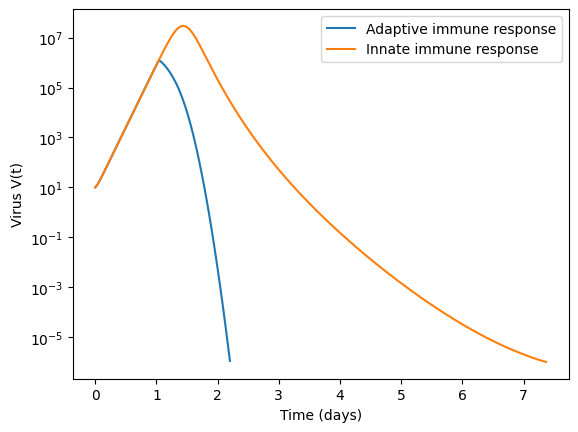

In [32]:
def full_model(t, y, params):
    H, I, V, C, N, T, B, A = y
    (λ, β, μ1, μ2, μ3, k,
     pC, pN, pT, pA,
     rC, μC, μN,
     rT, μT, rB, μB,
     α, μA) = params
    
    KT = 1e6
    KB = 1e6

    dHdt = λ - β * H * V - μ1 * H
    dIdt = β * H * V - pN * N * I - pT * T * I - μ2 * I
    dVdt = k * I - pC * C * V - pA * A * V - μ3 * V
    dCdt = rC * I - μC * C
    dNdt = rC * C - μN * N
    dTdt = rT * C * T * (1 - T/KT) - μT * T
    dBdt = rB * T * B * (1 - B/KB) - μB * B
    dAdt = α * B - μA * A - pA * A * V

    return [dHdt, dIdt, dVdt, dCdt, dNdt, dTdt, dBdt, dAdt]

params_full = [
    1e5, 2e-7, 0.01, 0.5, 5.0, 100.0,
    1e-5, 1e-4, 1e-4, 1e-5,
    1.0, 1.0, 0.5,
    1e-2, 0.2,
    1e-2, 0.2,
    5.0, 0.3
]

y0_immune = [
    1e7,  # H
    1.0,  # I
    10.0, # V
    0.0,  # C
    0.0,  # N
    1.0,  # T
    1.0,  # B
    0.0   # A  ← no antibodies initially
]

t_span = (0, 30)
t_eval = np.linspace(0, 30, 1500)

sol_immune = solve_ivp(
    full_model, t_span, y0_immune,
    args=(params_full,), t_eval=t_eval, method="BDF",
    rtol=1e-6,
    atol=1e-9,
    events=virus_clearance_event
)

plt.plot(sol_immune.t, sol_immune.y[2], label="Adaptive immune response")
plt.plot(sol_innate.t, sol_innate.y[2], label="Innate immune response")
plt.yscale("log")
plt.xlabel("Time (days)")
plt.ylabel("Virus V(t)")
plt.legend()
plt.show()


4. Add vaccination

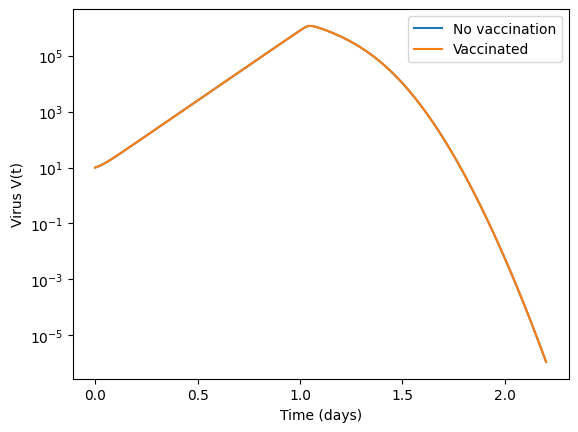

In [33]:
A0_vaccine = 200.0   # vaccine dose

y0_vaccine = y0_immune.copy()
y0_vaccine[7] = A0_vaccine   # antibodies present at t=0

sol_vaccine = solve_ivp(
    full_model, t_span, y0_vaccine,
    args=(params_full,), t_eval=t_eval,
    events=virus_clearance_event
)

plt.plot(sol_immune.t, sol_immune.y[2], label="No vaccination")
plt.plot(sol_vaccine.t, sol_vaccine.y[2], label="Vaccinated")
plt.yscale("log")
plt.xlabel("Time (days)")
plt.ylabel("Virus V(t)")
plt.legend()
plt.show()


5. Add antiviral drug

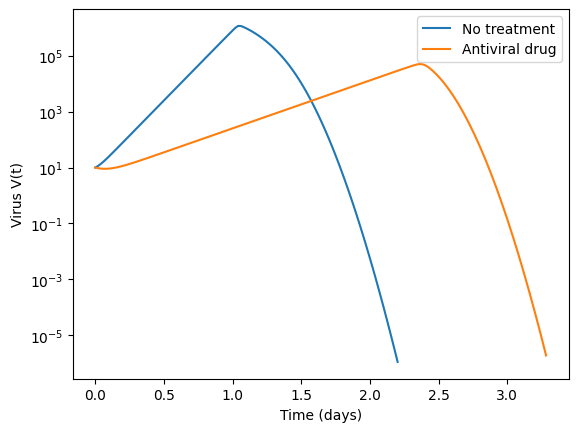

In [35]:
drug_efficacy = 0.8   # 80% efficacy

params_drug = params_full.copy()
params_drug[5] *= (1 - drug_efficacy)  # k → (1−ε)k

sol_drug = solve_ivp(
    full_model, t_span, y0_immune,
    args=(params_drug,), t_eval=t_eval,
    events=virus_clearance_event
)

plt.plot(sol_immune.t, sol_immune.y[2], label="No treatment")
plt.plot(sol_drug.t, sol_drug.y[2], label="Antiviral drug")
plt.yscale("log")
plt.xlabel("Time (days)")
plt.ylabel("Virus V(t)")
plt.legend()
plt.show()


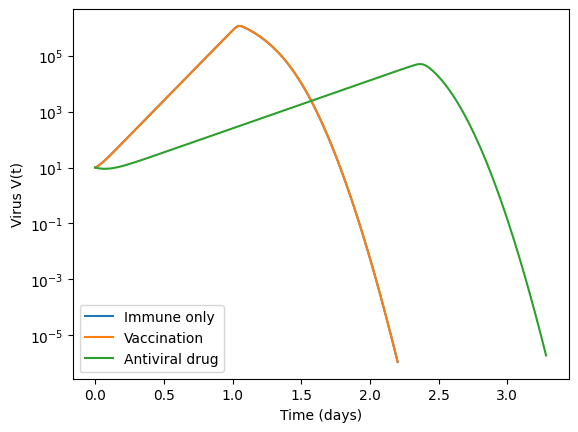

Peak V (immune only): 1174507.453568726
Peak V (vaccination): 1173777.7768813747
Peak V (drug): 50661.17054443888


In [36]:
plt.plot(sol_immune.t, sol_immune.y[2], label="Immune only")
plt.plot(sol_vaccine.t, sol_vaccine.y[2], label="Vaccination")
plt.plot(sol_drug.t, sol_drug.y[2], label="Antiviral drug")
plt.yscale("log")
plt.xlabel("Time (days)")
plt.ylabel("Virus V(t)")
plt.legend()
plt.show()

def peak_viral_load(solution):
    return np.max(solution.y[2])

print("Peak V (immune only):", peak_viral_load(sol_immune))
print("Peak V (vaccination):", peak_viral_load(sol_vaccine))
print("Peak V (drug):", peak_viral_load(sol_drug))


I AM OBTAINING IMMUNE ONLY AND VACCINATION SAME RESULTS
DRUG TREATMENT RESULTS WORSE THAN ONLY IMMUNE

COMPUTE R0, PLOT I(final) vs R0, COMPUTE Rt, EPIDEMIC THRESHOLD

STUDY STABILITY AND STATIONARY PONTS

CHECK PARAMETERS FROM ARTICLE

MODEL A DOSE-RESPONSE VACCINATION

MODEL IMMUNOSUPPRESSED